Francisco José Durá Galiana

# Red paralela para predicción de género y tempo (dB scaling)

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping

Using TensorFlow backend.


## Leer datos


In [3]:
# Parámetros de extracción de canciones
gtzan_dir = r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Datasets\GTZAN\genres"
data_df = pd.read_csv(r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Scripts\gtzan_clean.csv")
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
tempos = {'('+str(t)+', '+str(t+10)+']':i 
          for i,t in enumerate(range(data_df.tempo.astype(int).min(),data_df.tempo.astype(int).max(),10))}

In [4]:
# X = np.load('x_gtzan_npy.npy')
X = np.load('x_db_scaled.npy')
y1 = np.load('y1_gtzan_npy.npy')
# y2 = np.load('y2_gtzan_npy.npy')
y2 = np.load('y2_binned.npy')

In [5]:
y1 = to_categorical(y1)
y2 = to_categorical(y2)

## Partición de los datos

In [8]:
y = np.concatenate((y1,y2),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [9]:
y1_train = y_train[:,:10]
y1_test = y_test[:,:10]
y2_train = y_train[:,10:]
y2_test = y_test[:,10:]

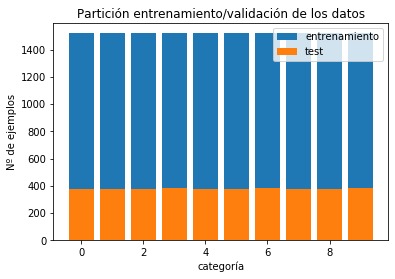

In [11]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y1_train, axis=1), return_counts=True)
plt.bar(values, count, label='entrenamiento')

values, count = np.unique(np.argmax(y1_test, axis=1), return_counts=True)
plt.bar(values, count, label='test')
plt.title('Partición entrenamiento/validación de los datos')
plt.xlabel('categoría')
plt.ylabel('Nº de ejemplos')
plt.legend()
plt.show()

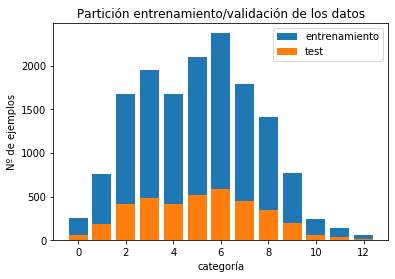

In [12]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y2_train, axis=1), return_counts=True)
plt.bar(values, count, label='entrenamiento')

values, count = np.unique(np.argmax(y2_test, axis=1), return_counts=True)
plt.bar(values, count, label='test')
plt.title('Partición entrenamiento/validación de los datos')
plt.xlabel('categoría')
plt.ylabel('Nº de ejemplos')
plt.legend()
plt.show()

## Construcción del modelo

In [13]:
# Model Definition
class MIR:
    
    def build(num_genres=10, num_tempos=13):
        input_shape = X_train[0].shape

        inputs = Input(shape=input_shape)
        # Conv Block 1
        x1 = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C1')(inputs)
        x1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='P1')(x1)
        x1 = Dropout(0.5, name='D1')(x1)

        # Conv Block H1
        x2 = Conv2D(32, kernel_size=(8, 2), strides=(1, 1), activation='relu', name='CH1')(x1)
        x2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='PH1')(x2)
        x2 = Dropout(0.5, name='DH1')(x2)

        # Conv Block H2
        x3 = Conv2D(64, kernel_size=(8, 2), strides=(1, 1), activation='relu', name='CH2')(x2)
        x3 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='PH2')(x3)
        x3 = Dropout(0.5, name='DH2')(x3)

        # Conv Block V1
        x4 = Conv2D(32, kernel_size=(2, 8), strides=(1, 1), activation='relu', name='CV1')(x1)
        x4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='PV1')(x4)
        x4 = Dropout(0.5, name='DV1')(x4)

        # Conv Block V2
        x5 = Conv2D(64, kernel_size=(2, 8), strides=(1, 1), activation='relu', name='CV2')(x4)
        x5 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='PV2')(x5)
        x5 = Dropout(0.5, name='DV2')(x5)

        # MLP
        yh = Flatten(name='H_out')(x3)
        yv = Flatten(name='V_out')(x5)
        
        y = keras.layers.Concatenate(axis=-1,name='Concat')([yh, yv])
#         y1 = Dense(168, activation='softmax', name="1_to_genre")(y)
#         y1 = Dropout(0.25, name='genre_dropout')(y1)
        y1 = Dense(num_genres, activation='softmax', name="genre")(y)
        
        y2 = Dense(32, activation='relu', name="2_to_tempo")(yv)
        y2 = Dense(16, activation='relu', name="1_to_tempo")(y2)
        y2 = Dense(num_tempos, activation='softmax',name="tempo")(y)

        model = Model(
            inputs=inputs,
#             outputs=[y1],
            outputs=[y1, y2],
            name="MIR_genre")
        
        return model

In [14]:
model = MIR.build()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 129, 1)  0                                            
__________________________________________________________________________________________________
C1 (Conv2D)                     (None, 126, 127, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
P1 (MaxPooling2D)               (None, 63, 63, 16)   0           C1[0][0]                         
__________________________________________________________________________________________________
D1 (Dropout)                    (None, 63, 63, 16)   0           P1[0][0]                         
__________________________________________________________________________________________________
CH1 (Conv2

## Entrenamiento del modelo

In [15]:
losses = {"genre": "categorical_crossentropy",
          "tempo": "categorical_crossentropy"}
loss_weights = {"genre": 1.0, "tempo": 1.0}

model.compile(loss=losses,loss_weights=loss_weights,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [16]:
tensorboard = TensorBoard(log_dir='./logs/scalars/mixed_split_4_fixed_db', histogram_freq=0, write_graph=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10)

hist = model.fit(X_train, [y1_train, y2_train],
          batch_size=32, # tamaño del batch de entrenamiento
          epochs=200, # Número de pases
          verbose=1, # Mostrar progreso
          validation_split=0.25,
          callbacks=[tensorboard, earlystop]) # Seleccionar un 25% de los datos para validación 

Train on 11400 samples, validate on 3800 samples
Epoch 1/200
11400/11400 [==============================] - 9s 763us/step - loss: 9.1021 - genre_loss: 4.3222 - tempo_loss: 4.7799 - genre_acc: 0.2236 - tempo_acc: 0.1454 - val_loss: 4.2060 - val_genre_loss: 1.8939 - val_tempo_loss: 2.3121 - val_genre_acc: 0.3503 - val_tempo_acc: 0.1903
Epoch 2/200
11400/11400 [==============================] - 7s 652us/step - loss: 3.7686 - genre_loss: 1.5750 - tempo_loss: 2.1936 - genre_acc: 0.4399 - tempo_acc: 0.1874 - val_loss: 3.7254 - val_genre_loss: 1.5413 - val_tempo_loss: 2.1841 - val_genre_acc: 0.4582 - val_tempo_acc: 0.2111
Epoch 3/200
11400/11400 [==============================] - 7s 654us/step - loss: 3.5201 - genre_loss: 1.3871 - tempo_loss: 2.1330 - genre_acc: 0.5020 - tempo_acc: 0.2201 - val_loss: 3.5333 - val_genre_loss: 1.4201 - val_tempo_loss: 2.1132 - val_genre_acc: 0.5145 - val_tempo_acc: 0.2737
Epoch 4/200
11400/11400 [==============================] - 7s 654us/step - loss: 3.2525 - 

## Resultados

In [17]:
score_test = model.evaluate(X_test, [y1_test, y2_test], verbose=0)
print("\t\t|-----------|-------|")
print("\tGenre\t| Precisión | Coste |")
print("+---------------+-----------+-------+")
print("| Entrenamiento\t|   {:5.3f}   | {:5.2f} |".format(hist.history['genre_acc'][-1], hist.history['genre_loss'][-1]))
print("| Validacion\t|   {:5.3f}   | {:5.2f} |".format(hist.history['val_genre_acc'][-1], hist.history['val_genre_loss'][-1]))
print("| Test\t\t|   {:5.3f}   | {:5.2f} |".format(score_test[3], score_test[1]))
print("+---------------+-----------+-------+")

print("\t\t|-----------|-------|")
print("\tTempo\t| Precisión | Coste |")
print("+---------------+-----------+-------+")
print("| Entrenamiento\t|   {:5.3f}   | {:5.2f} |".format(hist.history['tempo_acc'][-1], hist.history['tempo_loss'][-1]))
print("| Validacion\t|   {:5.3f}   | {:5.2f} |".format(hist.history['val_tempo_acc'][-1], hist.history['val_tempo_loss'][-1]))
print("| Test\t\t|   {:5.3f}   | {:5.2f} |".format(score_test[4], score_test[2]))
print("+---------------+-----------+-------+")

		|-----------|-------|
	Genre	| Precisión | Coste |
+---------------+-----------+-------+
| Entrenamiento	|   0.767   |  0.67 |
| Validacion	|   0.662   |  0.97 |
| Test		|   0.660   |  0.99 |
+---------------+-----------+-------+
		|-----------|-------|
	Tempo	| Precisión | Coste |
+---------------+-----------+-------+
| Entrenamiento	|   0.670   |  0.94 |
| Validacion	|   0.640   |  1.03 |
| Test		|   0.645   |  1.03 |
+---------------+-----------+-------+


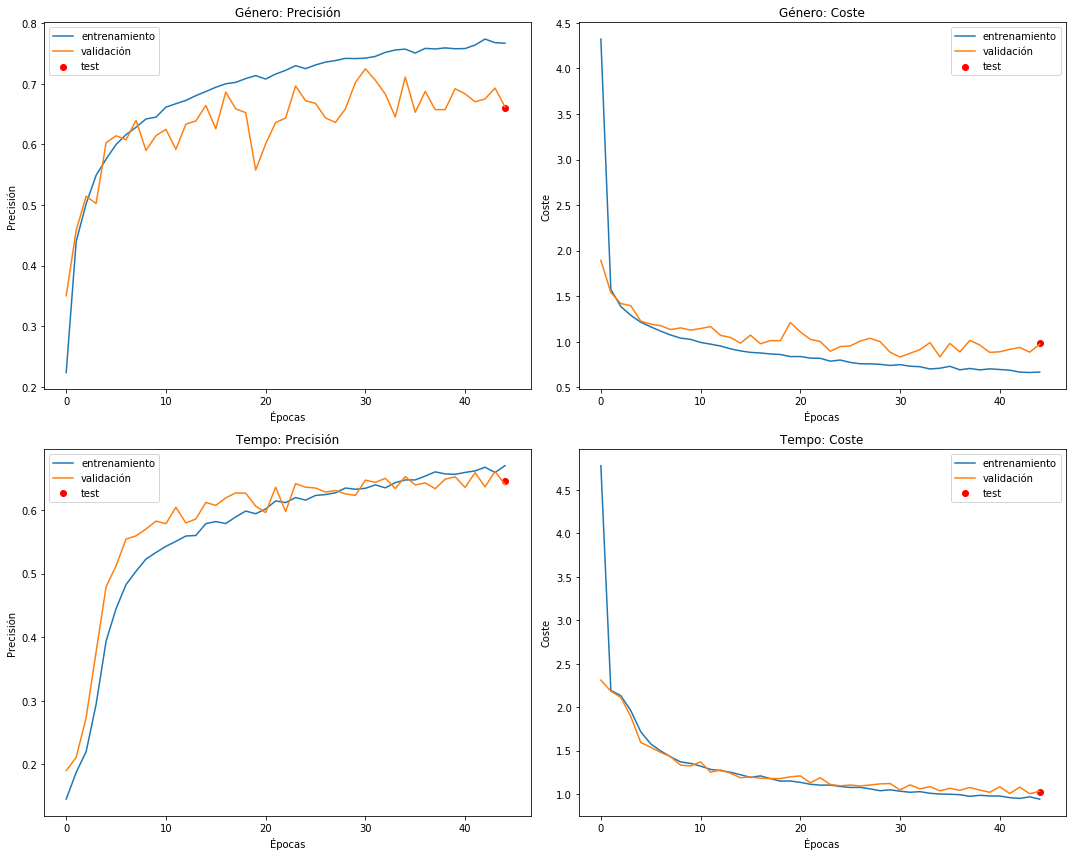

In [18]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.plot(hist.history['genre_acc'], label='entrenamiento')
plt.plot(hist.history['val_genre_acc'], label='validación')
plt.scatter(x=len(hist.history['genre_acc'])-1, y = score_test[3], c='red',label='test')
plt.title('Género: Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(2,2,2)
plt.plot(hist.history['genre_loss'], label='entrenamiento')
plt.plot(hist.history['val_genre_loss'], label='validación')
plt.scatter(x=len(hist.history['genre_loss'])-1, y = score_test[1], c='red',label='test')
plt.title('Género: Coste')
plt.xlabel('Épocas')
plt.ylabel('Coste')
plt.legend()

plt.subplot(2,2,3)
plt.plot(hist.history['tempo_acc'], label='entrenamiento')
plt.plot(hist.history['val_tempo_acc'], label='validación')
plt.scatter(x=len(hist.history['tempo_acc'])-1, y = score_test[4], c='red',label='test')
plt.title('Tempo: Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(2,2,4)
plt.plot(hist.history['tempo_loss'], label='entrenamiento')
plt.plot(hist.history['val_tempo_loss'], label='validación')
plt.scatter(x=len(hist.history['tempo_loss'])-1, y = score_test[2], c='red',label='test')
plt.title('Tempo: Coste')
plt.xlabel('Épocas')
plt.ylabel('Coste')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Si se elige normalize=True los valores de las filas se normalizaran
    if normalize:
        # normalizar sobre las filas (valores verdaderos)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # generar gráfico
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Generar ejes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Añadir anotaciones a celdas
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Género

In [20]:
preds = np.argmax(model.predict(X_test)[0], axis = 1)
y_orig = np.argmax(y1_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


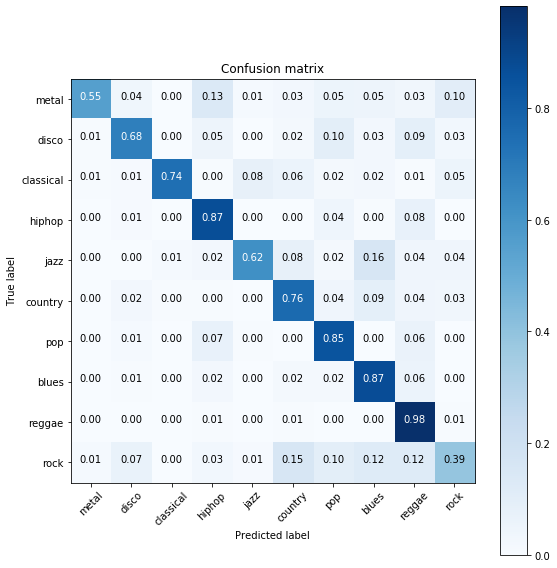

In [21]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys() # extraer nombres de categorías

plt.figure(figsize=(8,8)) 
plot_confusion_matrix(cm, keys, normalize=True)

### Tempo

In [22]:
preds = np.argmax(model.predict(X_test)[1], axis = 1)
y_orig = np.argmax(y2_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


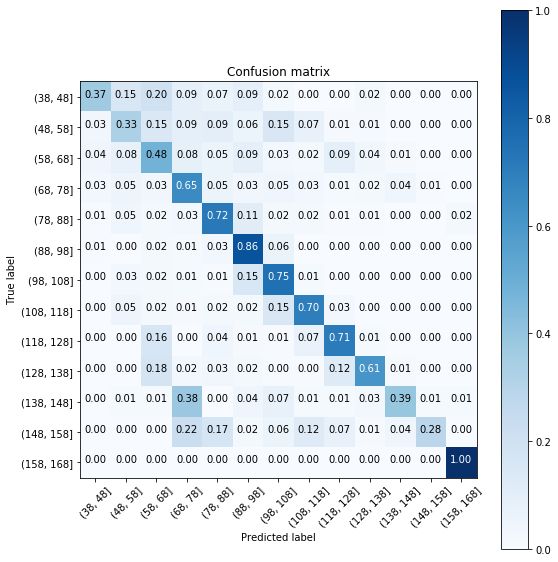

In [23]:
keys = OrderedDict(sorted(tempos.items(), key=lambda t: t[1])).keys() # extraer nombres de categorías

plt.figure(figsize=(8,8)) 
plot_confusion_matrix(cm, keys, normalize=True)

## Save the model
En el caso de que quisieramos guardar el modelo con sus pesos entrenados para uso futuro podemos utilizar la función `save()`:

In [24]:
# Save the model
# model.save('models/standard_split_2.h5')